## Load data

In [1]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from pathlib import Path
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop('records', axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['rep', 'fps', 'highquality', 'index'])
    return df


def make_df(path: str):
    with open(path, "r") as f:

        p = Path(path)

        x = p.stem.split("_")
        data = {}
        data['fps'] = int(x[1])
        data['highquality'] = x[3]

        rep_no = [x[-1] for x in path.split('/') if 'rep' in x][0]
        data['rep'] = int(rep_no)
        content = json.load(f)
        data['records'] = content['_checkpoint']['records']

        df = pd.DataFrame(data)
        return process_df(df)

In [3]:
dfs = []
path = "data/ronin/*/*/*.json"
for file_path in glob.glob(path):
    # print(file_path)
    dfs.append(make_df(file_path))

In [4]:
df_combined = pd.concat(dfs).sort_index()
df_combined = df_combined.drop(16, level=1, axis=0)

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7788 entries, (1, 10, 'False', 0) to (7, 20, 'True', 131)
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   route_id                           7788 non-null   object 
 1   status                             7788 non-null   object 
 2   infractions.collisions_layout      7788 non-null   object 
 3   infractions.collisions_pedestrian  7788 non-null   object 
 4   infractions.collisions_vehicle     7788 non-null   object 
 5   infractions.outside_route_lanes    7788 non-null   object 
 6   infractions.red_light              7788 non-null   object 
 7   infractions.route_dev              7788 non-null   object 
 8   infractions.route_timeout          7788 non-null   object 
 9   infractions.stop_infraction        7788 non-null   object 
 10  infractions.vehicle_blocked        7788 non-null   object 
 11  duration_game         

In [5]:
df_combined

route_id                    status infractions.collisions_layout infractions.collisions_pedestrian                     infractions.collisions_vehicle                    infractions.outside_route_lanes                              infractions.red_light infractions.route_dev infractions.route_timeout infractions.stop_infraction infractions.vehicle_blocked  duration_game  duration_system  route_length  score_composed  score_penalty  score_route  driving_score
rep fps highquality index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
1   10  False       0        RouteScenario_0  Failed - Agent timed out                            []                                []  [Agent collided against object with type=vehic...  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     301.100004       655.118260    350.831252        9.381381       0.335697    27.945936       0.093814
                    1        RouteScenario_1  Failed - Agent timed out                            []                                []  [Agent collided against object with type=vehic...  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     251.100004       522.494851    289.985251       16.334576       0.326406    50.043754       0.163346
                    2        RouteScenario_2  Failed - Agent timed out                            []                                []  [Agent collided against object with type=vehic...  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     228.100003       473.118934    272.631122       25.888396       0.572102    45.251365       0.258884
                    3        RouteScenario_3  Failed - Agent timed out                            []                                []                                                 []  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     128.100002       269.498117    153.049630       43.246647       0.976153    44.303132       0.432466
                    4        RouteScenario_4  Failed - Agent timed out                            []                                []                                                 []  [Agent went outside its route lanes for about ...  [Agent ran a red light 997 at (x=129.55, y=226...                    []          [Route timeout.]                          []                          []     190.100003       395.243434    218.597426       11.796465       0.648559    18.188726       0.117965
...                                      ...                       ...                           ...                               ...                                                ...                                                ...                                                ...                   ...                       ...                         ...                         ...            ...              ...           ...             ...            ...          ...            ...
7   20  True        127    RouteScenario_127                

## FPS factor, in high fidelity

In [6]:
df = df_combined.xs("True", level='highquality', drop_level=False)
df

route_id                      status                      infractions.collisions_layout infractions.collisions_pedestrian                     infractions.collisions_vehicle                    infractions.outside_route_lanes infractions.red_light infractions.route_dev infractions.route_timeout infractions.stop_infraction                        infractions.vehicle_blocked  duration_game  duration_system  route_length  score_composed  score_penalty  score_route  driving_score
rep fps highquality index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
1   10  True        0        RouteScenario_0    Failed - Agent timed out  [Agent collided against object with type=stati...                                []                                                 []  [Agent went outside its route lanes for about ...                    []                    []          [Route timeout.]                          []                                                 []     301.100004       661.616342    350.831252       29.267785       0.416031    70.350080       0.292678
                    1        RouteScenario_1  Failed - Agent got blocked                                                 []                                []                                                 []  [Agent went outside its route lanes for about ...                    []                    []                        []                          []  [Agent got blocked at (x=177.148, y=190.898, z...     190.400003       459.499749    289.985251        5.515321       0.726857     7.587907       0.055153
                    2        RouteScenario_2    Failed - Agent timed out                                                 []                                []                                                 []  [Agent went outside its route lanes for about ...                    []                    []          [Route timeout.]                          []                                                 []     228.100003       500.725377    272.631122       26.015119       0.943655    27.568479       0.260151
                    3        RouteScenario_3    Failed - Agent timed out                                                 []                                []                                                 []  [Agent went outside its route lanes for about ...                    []                    []          [Route timeout.]                          []                                                 []     128.100002       276.852260    153.049630       42.771830       0.965436    44.303132       0.427718
                    4        RouteScenario_4    Failed - Agent timed out                                                 []                                []                                                 []  [Agent went outside its route lanes for about ...                    []                    []          [Route timeout.]                          []                                                 []     190.100003       440.362709    218.597426       16.852092       0.884478    19.053149       0.168521
...                                      ...                         ...                                                ...                               ...                                                ...                                                ...                   ...                   ...                       ...                         ...                                                ...            ...              .

In [7]:


# df = df.reset_index()
df.groupby('fps')["score_composed"].mean().sort_index(ascending=False)

fps
20    86.145020
18    86.585513
17    84.117739
15    80.318854
14    75.664726
12    59.339624
10    48.476912
Name: score_composed, dtype: float64

In [8]:
def plot(column: str, ax=None, col="b", marker='s'):
    axes = df.groupby('fps')[column].mean().sort_index(
        ascending=False).plot(linestyle='dashed', marker=marker, color=col,)

    return axes

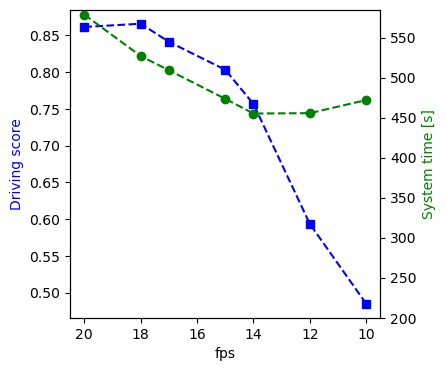

In [9]:
fig, axes = plt.subplots(squeeze=True)
fig.set_size_inches(4, 4)
axes = plot("driving_score", axes)
axes.set_ylabel(f"Driving score", color='b')

axes = plot("duration_system", axes.twinx(), 'g', marker='o')
axes.set_ylabel(f"System time [s]", color='g')
axes.set_ylim(200)
axes.invert_xaxis()
fig.savefig('plot.pdf', bbox_inches='tight')
# fig

### Error bars

In [10]:
df.groupby(["rep"])["driving_score"].mean()

rep
1    0.741575
2    0.743332
3    0.743499
4    0.743808
5    0.742890
6    0.746859
7    0.744521
Name: driving_score, dtype: float64

### ^ Pretty consitent repetitions

In [11]:
# mean across all scenarios
agg = df.groupby(["fps", "rep"])["driving_score"].mean()

In [12]:
agg.groupby("fps").min()
agg.groupby("fps").max()
agg.groupby("fps").mean()

fps
10    0.484769
12    0.593396
14    0.756647
15    0.803189
17    0.841177
18    0.865855
20    0.861450
Name: driving_score, dtype: float64

In [13]:
def plot_better(df, ax, column, style, err=True):
    agg = df.groupby(["fps", "rep"])[column].mean()
    mean = agg.groupby("fps").mean()

    range = np.vstack([np.abs(agg.groupby("fps").min()-mean),
                       np.abs(agg.groupby("fps").max()-mean)])

    yerr = range if err else None

    ax.errorbar(
        mean.index,
        mean,
        yerr=yerr,
        **style)
    return ax

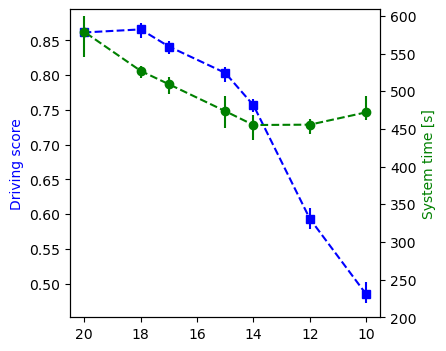

In [14]:
fig, ax = plt.subplots(squeeze=True)
fig.set_size_inches(4, 4)

style = dict(linestyle='dashed', marker='s', color='blue',)
ax = plot_better(df, ax, "driving_score", style)
ax.set_ylabel(f"Driving score", color='b')

style = dict(linestyle='dashed', marker='o', color='green',)
ax = plot_better(df, ax.twinx(), "duration_system", style)
ax.set_ylabel(f"System time [s]", color='g')

ax.set_ylim(200)
ax.invert_xaxis()

### ^ Error bars for driving score more consistent than system time

Normalize system time

In [15]:
oracle = df.xs(20, level='fps', drop_level=False).sort_index()

# oracle

In [16]:
# average time to perform each scenario
df['norm_sys_time'] = df['duration_system'] / \
    oracle.groupby('index')["duration_system"].mean()

/tmp/ipykernel_57927/2647730776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_sys_time'] = df['duration_system'] / \


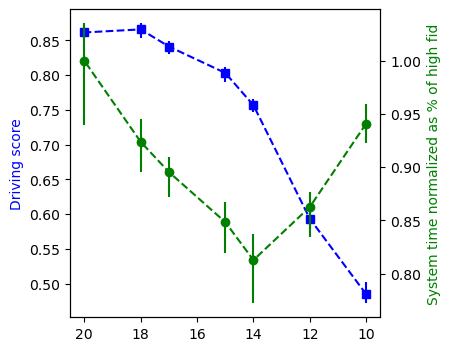

In [17]:
fig, ax = plt.subplots(squeeze=True)
fig.set_size_inches(4, 4)

style = dict(linestyle='dashed', marker='s', color='blue',)
ax = plot_better(df, ax, "driving_score", style)
ax.set_ylabel(f"Driving score", color='b')


style = dict(linestyle='dashed', marker='o', color='green',)
ax = plot_better(df, ax.twinx(), "norm_sys_time", style)
ax.set_ylabel(f"System time normalized as % of high fid", color='g')

ax.invert_xaxis()

### Prediction error

In [18]:


df['square_error'] = (df['driving_score'] -
                      oracle.groupby('index')['driving_score'].mean()).pow(2).pow(1./2)

/tmp/ipykernel_57927/2806949529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['square_error'] = (df['driving_score'] -


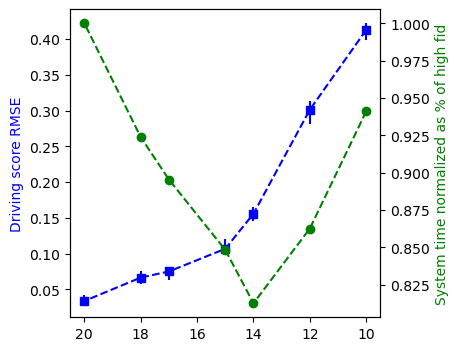

In [19]:
fig, ax = plt.subplots(squeeze=True)
fig.set_size_inches(4, 4)

style = dict(linestyle='dashed', marker='s', color='blue',)
ax = plot_better(df, ax, "square_error", style)
ax.set_ylabel(f"Driving score RMSE", color='b')


style = dict(linestyle='dashed', marker='o', color='green',)
ax = plot_better(df, ax.twinx(), "norm_sys_time", style,)
ax.set_ylabel(f"System time normalized as % of high fid", color='g')

ax.invert_xaxis()